In [10]:
import numpy as np
import nibabel as nib
from argparse import Namespace

from utils.SAMMed3D_segment_anything.build_sam import sam_model_registry
from classes.SAMClass import SAMWrapper, SAMInferer
import utils.promptUtils as prUt
import utils.analysisUtils as anUt

def load_sam(checkpoint_path, device):
    args = Namespace()
    args.image_size = 256
    args.sam_checkpoint = checkpoint_path
    args.model_type = 'vit_h'
    model = sam_model_registry[args.model_type](args).to(device)
    return(model)

def read_im_gt(img_path, gt_path):
    img, gt = nib.load(img_path), nib.load(gt_path)

    ## Check if the volume is already in RAS+
    if nib.aff2axcodes(img.affine) != ('R', 'A', 'S'):
        raise RuntimeWarning('Image not in RAS. Consider reorienting here')
        img_ras = nib.as_closest_canonical(volume_img)

    if nib.aff2axcodes(gt.affine) != ('R', 'A', 'S'):
        raise RuntimeWarning('Label not in RAS. Consider reorienting here')
        gt_ras = nib.as_closest_canonical(gt)

    img, gt = img.get_fdata().astype(np.float32), gt.get_fdata().astype(int)
    img, gt = img.transpose(2,1,0), gt.transpose(2,1,0) # Convert from RAS (xyz) to row-major (zyx)
    # img = img.transpose(2,1,0)
    return(img, gt)

# Load in model
device = 'cuda'
checkpoint_path = '/home/t722s/Desktop/UniversalModels/TrainedModels/sam_vit_h_4b8939.pth'
sam_model = load_sam(checkpoint_path, device)

# Load in image, label, prompt
img_path = '/home/t722s/Desktop/Datasets/BratsMini/imagesTs/BraTS2021_01646.nii.gz'
gt_path = '/home/t722s/Desktop/Datasets/BratsMini/labelsTs/BraTS2021_01646.nii.gz'

img, gt = read_im_gt(img_path, gt_path)

pts_prompt = prUt.get_pos_clicks2D_row_major(gt, 5)

# Perform inference
sam_wrapper = SAMWrapper(sam_model, device)
segmenter = SAMInferer(sam_wrapper, device)

segmentation = segmenter.predict(img, pts_prompt)

anUt.compute_dice(segmentation, gt)

*******interpolate
*******load /home/t722s/Desktop/UniversalModels/TrainedModels/sam_vit_h_4b8939.pth


Performing inference on slices: 100%|██████████| 47/47 [00:03<00:00, 12.15it/s]


0.5771735280494782

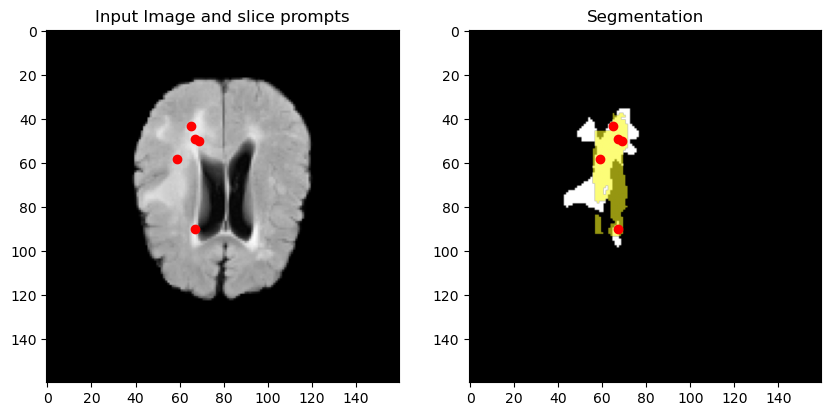

0.5727341964965728

In [11]:
# Slice visualisation:
slice_idx = 60
anUt.show_seg_row_major(slice_idx, img, gt, segmentation, pts_prompt= pts_prompt)